<!--
SPDX-FileCopyrightText: Copyright (c) 2019-2024 Idiap Research Institute <contact@idiap.ch>
SPDX-FileContributor: Alina Elena Baia <alina.baia.idiap.ch>
SPDX-FileContributor: Darya Baranouskaya <darya.baranouskaya.idiap.ch>
SPDX-FileContributor: Olena Hrynenko <olena.hrynenko.idiap.ch>
SPDX-FileContributor: Olivier Canévet <olivier.canevet@idiap.ch>
-->
# Practice exercises after Lecture 2
This notebook contains the practice exercises with instructions and explanations.

You will explore different aspects related to data: quality, collection, and loading.

Work through the cells below in sequential order, executing each cell as you progress. Throughout the notebook, you will encounter instructions marked with the words **YOUR CODE HERE** followed by **raise NotImplementedError()**. You will have to substitute  *raise NotImplementedError()* with your own code.
Follow the instructions and write the code to complete the tasks.

Along the way, you will also find questions. Try to reflect on the questions before/after running the code.

This notebook was developped at the [Idiap Research Institute](https://www.idiap.ch) by [Alina Elena Baia](mailto:alina.baia.idiap.ch>), [Darya Baranouskaya](mailto:darya.baranouskaya.idiap.ch) and [Olena Hrynenko](mailto:olena.hrynenko.idiap.ch).
Some pieces of code were adopted from the notebooks developed at the  [Idiap Research Institute](https://www.idiap.ch) by [Olivier Canévet](mailto:olivier.canevet@idiap.ch). 

In [1]:
import pandas as pd
import torch
import numpy as np
from torch import nn
import os
import re

In [2]:
# This piece of code is adopted from the notebooks developed at the Idiap Research Institute by Olivier Canévet.
# For efficient usage of the hardware resources when running on JupyterHub (EPFL),
# we will limit the number of threads. If you are running this code on your local
# machine or on colab, the following code will not do anything.

# if getpass.getuser() == "jovyan":
#     num_threads_limit = 4
if re.search('^https://.*noto.*\.epfl\.ch$', os.environ.get("EXTERNAL_URL", "")) != None:
    num_threads_limit = 2
else:
    num_threads_limit = torch.get_num_threads()
print(f"Limiting the number of threads to {num_threads_limit}")
torch.set_num_threads(num_threads_limit)
print(f"PyTorch is using {torch.get_num_threads()} threads")

_ = torch.set_flush_denormal(True) # To avoid long training time on CPU

Limiting the number of threads to 4
PyTorch is using 4 threads


# Investigating bias in the models caused by the data
This exercise focuses on the exploration of the bias within and across different text encoders in the context of job gender bias. The bias in these models is caused by the training data on which the encoders were trained. The exercise examines the bias of the following text encoders: GloVe, SentenceBert, and CLIP.
  - GloVe https://huggingface.co/sentence-transformers/average_word_embeddings_glove.6B.300d , https://nlp.stanford.edu/projects/glove/,
  - SentenceBert https://www.sbert.net/, https://arxiv.org/abs/1908.10084
  - CLIP https://huggingface.co/sentence-transformers/clip-ViT-B-32, https://arxiv.org/abs/2103.00020



Text encoding refers to the process that transforms textual information into numerical representations that maintains the meaning and the relationships between words. This representation, known as vector embedding, allows machines to identify  and understand patterns in the text and determine the context of the text.

Embeddings show interesting substructures of the word embedding space. For example, in GloVe we observe the following:

<div style="max-width:100%; margin:auto; padding:10px;">

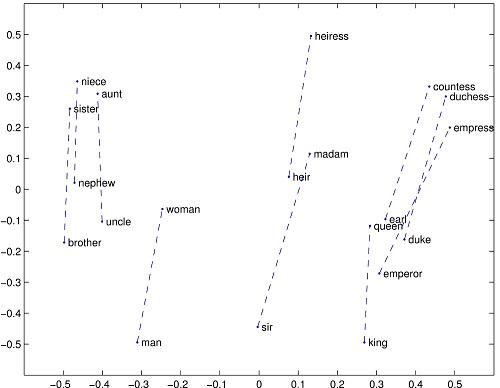

</div>

<div style="max-width:100%; margin:auto; padding:10px;">

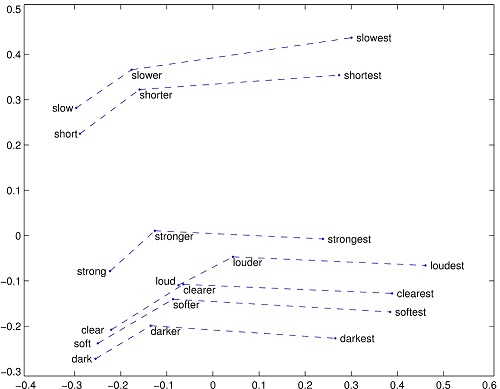

</div>
---------------------------------------------------------------------------------------------

Some references:

An intuitive introduction to text embeddings:
https://stackoverflow.blog/2023/11/09/an-intuitive-introduction-to-text-embeddings/

Word Embedding Analogies:
https://kawine.github.io/blog/nlp/2019/06/21/word-analogies.html

Nurse is Closer to Woman than Surgeon? Mitigating Gender-Biased Proximities in Word Embeddings:
https://arxiv.org/abs/2006.01938

Gender Bias in Word Embeddings: A Comprehensive Analysis of Frequency, Syntax, and Semantics:
https://arxiv.org/abs/2206.03390

Text Embedding Models Contain Bias. Here's Why That Matters:
https://developers.googleblog.com/2018/04/text-embedding-models-contain-bias.html

---------------------------------------------------------------------------------------------



You are provided with a list of 100 job titles (jobs are the output to ChatGPT 3.5 Prompt: “Provide a list of 100 jobs”). You will learn how to embed the job titles and words “man” and “woman”. You will compute the similarity between embedded job titles and the words “man” and “woman”.  

Since words are represented as numerical vectors in the embedding space, words are similar if their vector embeddings are close in the space. We can use the cosine similarity to measure the similarity between two vectors, defined as:
$$similarity = \cos (\theta ) =   \dfrac {A \cdot B} {\left\| A\right\| _{2}\left\| B\right\| _{2}}, $$
where $A,B$ are the word embedding vectors and $\theta$  is the angle between the vectors.

The smaller the angle between the two vectors, the greater their similarity to each other.
The cosine similarity can have values between in the range $[-1, 1]$: a value closer to 1 indicates higher similarity.
Thus, using cosine similarity we can quantify how similar/close two words are.


<div style="max-width:100%; margin:auto; padding:10px;">

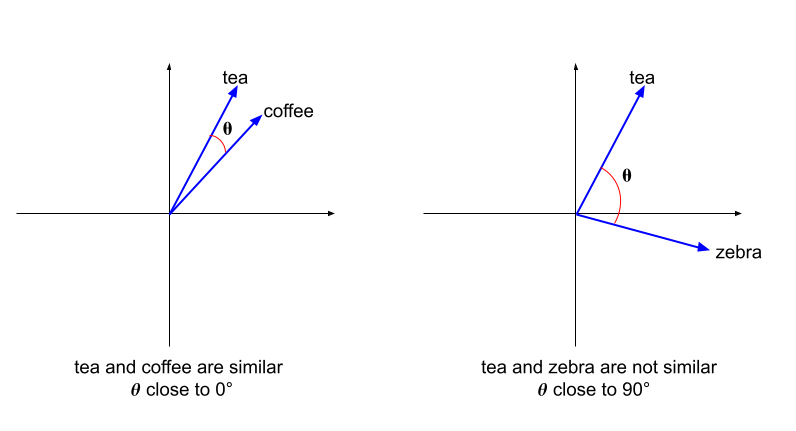

</div>

In the exercise we will use the $cosine\_similarity(A,B)$ function from sklearn.
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

In [6]:
# if you are using Noto you can skip this step
# if you are using Google Colab or running the code locally, make sure to install sentence-transformers:
# https://huggingface.co/sentence-transformers
# pip install -U sentence-transformers

In [5]:
import numpy as np
import pandas as pd

# import libraries necessary for generating text embeddings
#in this exercises we will be working with Sentence Transformers:
#check out the documentation at: https://www.sbert.net/ or https://huggingface.co/sentence-transformers

from sentence_transformers import SentenceTransformer, util

#cosine similarity to compute the similarity between two chunks of text (i.e. similarity between the vector embeddings)
from sklearn.metrics.pairwise import cosine_similarity


# NOTE: make sure to upload the file with the jobs in the colab session
# read the csv file containing the list of jobs

jobs = pd.read_csv("jobs.csv")

# apply lowercase to the jobs titles and save the jobs in a list
jobs_list = jobs["job"].str.lower().to_list()

gender_list = ["man","woman"]

#get the SentenceBert emcoder model
#
sb_model = SentenceTransformer("all-MiniLM-L6-v2", device="cpu")

##get the CLIP emcoder model
#
clip_model = SentenceTransformer('clip-ViT-B-32', device="cpu")

##get the GloVe emcoder model
#
glove_model = SentenceTransformer('sentence-transformers/average_word_embeddings_glove.6B.300d', device="cpu")




/home/nathan/Documents/Deep_Learning/dlenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/nathan/Documents/Deep_Learning/dlenv/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/nathan/Documents/Deep_Learning/dlenv/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/nathan/Documents/Deep_Learning/dlenv/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word

Computing Embeddings: the method to encode text is model.encode()


Check out the documenation to see the parameters of this method: https://www.sbert.net/examples/applications/computing-embeddings/README.html

For today's exercise we will use the following parameters:
- sentences: the sentences/words to embed, passed as a list of strings
- convert_to_numpy: whether the output should be a list of numpy vectors. If False, it is a list of PyTorch tensors. Default value is True.

In [8]:

# TODO define a function that creates a dataframe containing the cosine
#      similarities between the jobs tittles and the words "man" and woman;
#      take as paramters the list of jobs, the list of genders and text encoder
#      returns a dataframe with 3 columns (jobs, man, woman), where
#        - column jobs contains the list of jobs
#        - column man contains the cosine similarity values between a job and man
#        - column woman contains the cosine similarity values between a job and woman

def get_cosine_similarities(jobs_list, gender_list, model):

    """
      Create a dataframe with 3 columns (jobs, man, woman), where:
        - column jobs contains the list of jobs
        - column man contains the cosine similarity values between a job title and man
        - column woman contains the cosine similarity values between a job title and woman

      Arguments:
        jobs_list : list with the job tittles
        gender_list: list with the genders (i.e. man, woman)
        model :  the model to use for generating the word embeddings
    """

    #call the encoding method corresponding to the specific model on the list of jobs
    # (1 line of code)
    embeddings_jobs = model.encode(jobs_list)

    # YOUR CODE HERE
    # raise NotImplementedError()

    #call the encoding method corresponding to the specific model on the list of genders
    # (1 line of code)
    embeddings_gender = model.encode(gender_list)

    # YOUR CODE HERE
    # raise NotImplementedError()

    #compute consine similarities between jobs embeddings and gender embeddings
    #check out the documentation of cosine_similarity() from sklearn for the usage of this function
    # (1 line of code)

    # YOUR CODE HERE
    cosine_scores = cosine_similarity(embeddings_jobs, embeddings_gender)

    # raise NotImplementedError()

    #create the dataframe to store the cosine similarities values
    sim_df =  pd.DataFrame(zip(jobs_list, cosine_scores[:,0], cosine_scores[:,1]), columns=['jobs', gender_list[0], gender_list[1]])

    return sim_df



In [11]:
# use get_cosine_similaritities() function defined above to create and save a datataframe
# with the similarities between jobs titles and genders for each of the
# three encoders: SentenceBert, CLIP, GloVe

print("dataframe: similarities with SB")
jobs_SB = get_cosine_similarities(jobs_list, gender_list, sb_model)
jobs_SB.to_csv("jobs_gender_similarity_SB.csv")
print(jobs_SB.head())

print()
print("dataframe: similarities with CLIP")
jobs_CLIP = get_cosine_similarities(jobs_list, gender_list, clip_model)
jobs_CLIP.to_csv("jobs_gender_similarity_CLIP.csv")
print(jobs_CLIP.head())

print()
print("dataframe: similarities with GLOVE")
jobs_GLOVE = get_cosine_similarities(jobs_list, gender_list, glove_model)
jobs_GLOVE.to_csv("jobs_gender_similarity_GLOVE.csv")
print(jobs_GLOVE.head())

dataframe: similarities with SB
                 jobs       man     woman
0  software developer  0.201801  0.246858
1               nurse  0.158204  0.429275
2          accountant  0.156342  0.255507
3             teacher  0.226123  0.387016
4   marketing manager  0.252136  0.234002

dataframe: similarities with CLIP
                 jobs       man     woman
0  software developer  0.833605  0.834213
1               nurse  0.828521  0.853283
2          accountant  0.822021  0.832009
3             teacher  0.860456  0.878528
4   marketing manager  0.827147  0.841635

dataframe: similarities with GLOVE
                 jobs       man     woman
0  software developer  0.152181  0.054567
1               nurse  0.237300  0.449636
2          accountant  0.161228  0.185455
3             teacher  0.304239  0.427211
4   marketing manager  0.223544  0.128934


##### 2.1 For each job title, compute the difference between the cosine similarity of the word “man” and the job title, and “woman” and the job title:

\begin{equation}
      \Delta = cos(job_x, man) - cos(job_x, woman)
\end{equation}

with $x \in \{job_1, \dots , job_n\}$, where $n$ is the number of job titles and $cos()$ is the function that computes the cosine similarity. The $\Delta$ indicates if a job is perceived as more *feminine* (negative value), more *masculine* (positive value), or *gender-neutral* (zero value) by the encoder.  Plot the delta values for all encoders (GloVe, SentenceBert, CLIP).

In [12]:
# jobs_SB = pd.read_csv("/content/jobs_gender_similarity_SB.csv")
# jobs_CLIP = pd.read_csv("/content/jobs_gender_similarity_CLIP.csv")
# jobs_GLOVE = pd.read_csv("/content/jobs_gender_similarity_GLOVE.csv")

#compute the delta values by computing the difference between values in
# column man and values in column woman
# (3 lines of code, one line for each text encoder)
# jobs_SB["delta"] = ...
# jobs_CLIP["delta"] = ...
# jobs_GLOVE["delta"] = ...

# YOUR CODE HERE
jobs_SB["delta"] = jobs_SB["man"] - jobs_SB["woman"]
jobs_CLIP["delta"] = jobs_CLIP["man"] - jobs_CLIP["woman"]
jobs_GLOVE["delta"] = jobs_GLOVE["man"] - jobs_GLOVE["woman"]
# raise NotImplementedError()
print(jobs_SB.head())

# sort the values in the dataframe by alphabetically by jobs titles
jobs_sorted_SB = jobs_SB.sort_values(by = "jobs", axis=0)
jobs_sorted_CLIP = jobs_CLIP.sort_values(by = "jobs", axis=0)
jobs_sorted_GLOVE = jobs_GLOVE.sort_values(by = "jobs", axis=0)

print()
print("jobs sorted")
print(jobs_sorted_SB.head())


                 jobs       man     woman     delta
0  software developer  0.201801  0.246858 -0.045057
1               nurse  0.158204  0.429275 -0.271070
2          accountant  0.156342  0.255507 -0.099165
3             teacher  0.226123  0.387016 -0.160893
4   marketing manager  0.252136  0.234002  0.018134

jobs sorted
                   jobs       man     woman     delta
60     academic advisor  0.119214  0.280172 -0.160957
2            accountant  0.156342  0.255507 -0.099165
87  advertising manager  0.264040  0.226104  0.037936
52   aerospace engineer  0.133567  0.223814 -0.090247
83       animal trainer  0.119783  0.197533 -0.077750


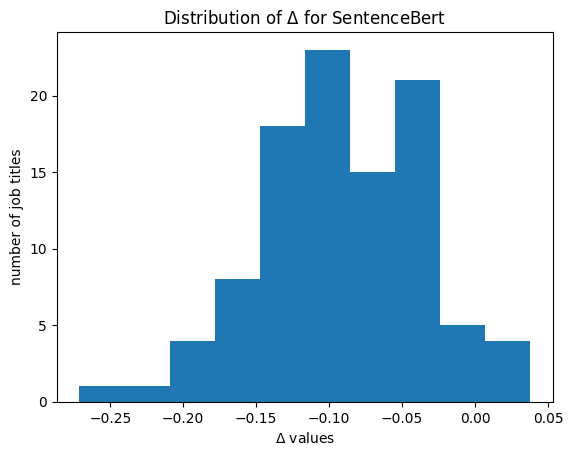

In [13]:
import matplotlib.pyplot as plt
#plot the histrogram of delta values
plt.hist(jobs_sorted_SB["delta"])
plt.xlabel("$\Delta$ values")
plt.ylabel("number of job titles")
plt.title("Distribution of $\Delta$ for SentenceBert")
plt.show()

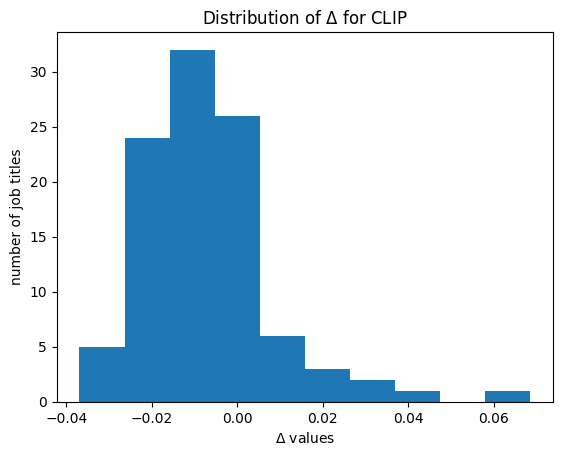

In [14]:
plt.hist(jobs_sorted_CLIP["delta"])
plt.xlabel("$\Delta$ values")
plt.ylabel("number of job titles")
plt.title("Distribution of $\Delta$ for CLIP")
plt.show()

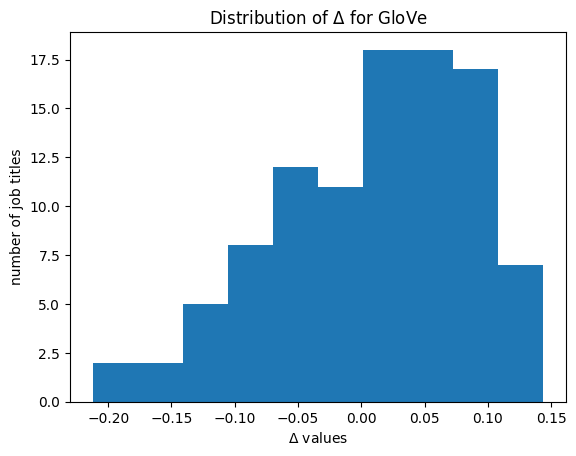

In [15]:
plt.hist(jobs_sorted_GLOVE["delta"])
plt.xlabel("$\Delta$ values")
plt.ylabel("number of job titles")
plt.title("Distribution of $\Delta$ for GloVe")
plt.show()

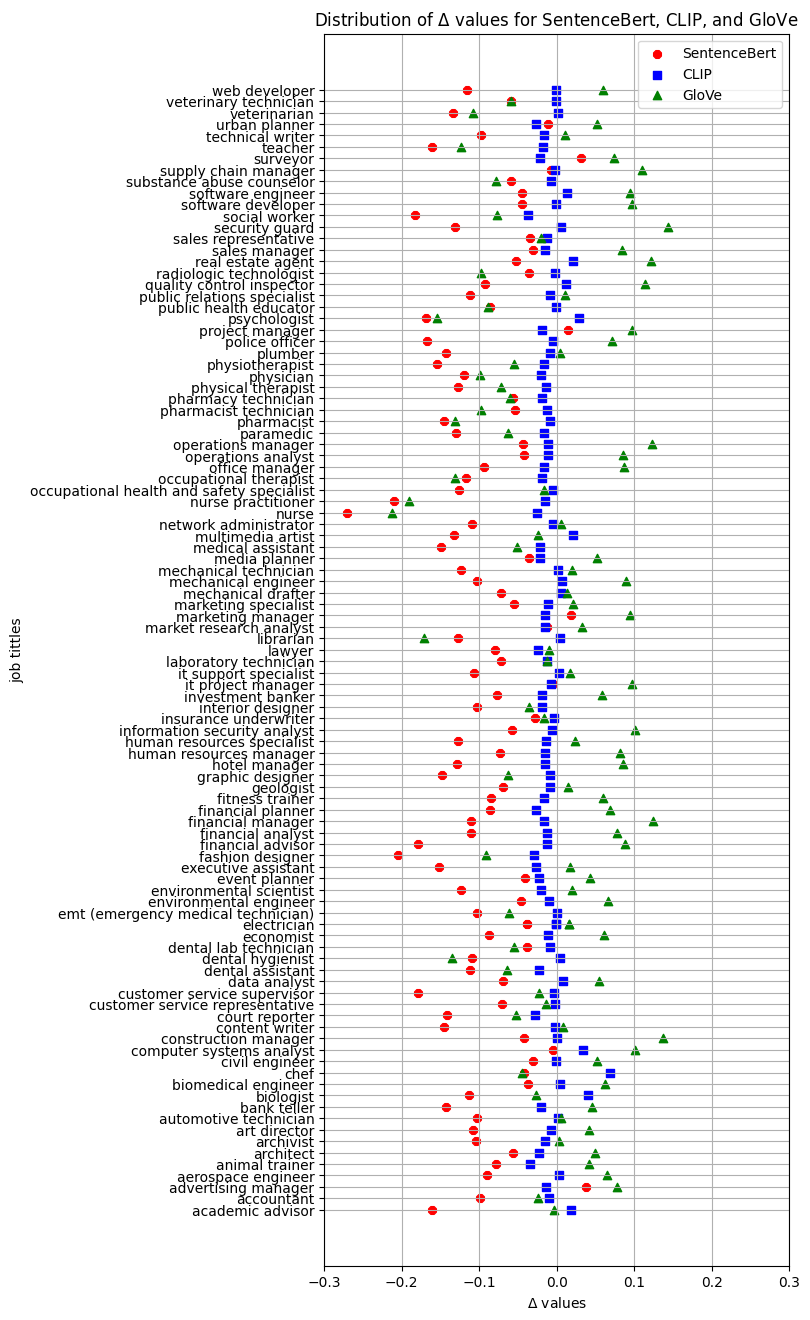

In [16]:
#plot the delta values
plt.figure(figsize=(6, 16))
plt.scatter(jobs_sorted_SB["delta"], jobs_sorted_SB["jobs"], color="red", marker="8", label ="SentenceBert")
plt.scatter(jobs_sorted_CLIP["delta"], jobs_sorted_CLIP["jobs"], color="blue", marker="s", label ="CLIP")
plt.scatter(jobs_sorted_GLOVE["delta"], jobs_sorted_GLOVE["jobs"], color="green", marker= "^", label ="GloVe")
plt.xlabel("$\Delta$ values")
plt.ylabel("job tittles")
plt.title("Distribution of $\Delta$ values for SentenceBert, CLIP, and GloVe")
plt.legend()
plt.xlim(-0.3, 0.3)
plt.grid()

#### 2.2 Compute the variance and the mean of the delta values per model.
Consider the following questions:

Within each model: is the mean higher or lower than 0? What does it mean?

Across models: which model has the lowest / highest variance / mean? Which models are the closest to 0 (zero mean, smallest distribution)?    



In [18]:
#TODO compute the variance and the mean of the delta values per text encoder
# 2 lines of code for each text encoder
# sb_std = ...
# sb_mean = ...
# YOUR CODE HERE
# raise NotImplementedError()
sb_std = jobs_sorted_SB["delta"].std()
sb_mean = jobs_sorted_SB["delta"].mean()
print(sb_std, sb_mean)

# clip_std = ...
# clip_mean = ...
# YOUR CODE HERE
# raise NotImplementedError()
clip_std = jobs_sorted_CLIP["delta"].std()
clip_mean = jobs_sorted_CLIP["delta"].mean()
print(clip_std, clip_mean)

# glove_std = ...
# glove_mean = ...
# YOUR CODE HERE
# raise NotImplementedError()
glove_std = jobs_sorted_GLOVE["delta"].std()
glove_mean = jobs_sorted_GLOVE["delta"].mean()
print(glove_std, glove_mean)

0.05568784 -0.09034558
0.015704261 -0.0073830173
0.07912633 0.0074378075


# Familiarizing with the dataset and image augmentation

The code in this section is adopted from the notebooks developed at the  [Idiap Research Institute](https://www.idiap.ch) by [Olivier Canévet](mailto:olivier.canevet@idiap.ch). 

##### 2.3 Learn to load an image dataset, create a dataset loader and image batches.

We are going to load a dataset composed of images of the following fruits: apple, banana, bean, carrot, grape, onion, pear, potato, strawberry, tomato.

The dataset has the following structure:

```text
fruits/
|-- train/
|   |-- apple/
|   |   |-- 000.jpg
|   |   |-- 001.jpg
|   |   |-- ...
|   |-- banana/
|   |   |-- 000.jpg
|   |   |-- 001.jpg
|   |   |-- ...
|
|-- val/
|   |   |-- 040.jpg
|   |   |-- 041.jpg
|   |   |-- ...
|   |-- banana/
|   |   |-- 040.jpg
|   |   |-- 041.jpg
|   |   |-- ...
```

which can be loaded as is with the ImageFolder class of PyTorch.
Check out the documentation for more details: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

In [ ]:
# uncomment the code below if you are using colab and want to save the dataset in your Google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [22]:
import getpass
import os
import random
import re
import tarfile
import time

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.utils as utils
import torchvision.transforms as transforms

In [23]:
# set up the location where the daa will be downloaded
from pathlib import Path

#for today's exercises we will create a folder to store the downloaded data
DATADIR = "fruit_dataset"
print("Using data directory {}".format(DATADIR))

if not os.path.exists(Path(DATADIR)):
    os.makedirs(Path(DATADIR))

Using data directory fruit_dataset


In [24]:
# download the dataset with the following code
url = "https://www.idiap.ch/~ocanevet/master-ai/fruits.tgz"
DATA_TAR_FILE = Path(DATADIR) / "fruits.tgz"
if not Path(DATA_TAR_FILE).is_file():
    print(f"Downloading data set to {DATA_TAR_FILE}")
    datasets.utils.download_and_extract_archive(url, download_root=DATADIR)
else:
    print(f"Data set already in {DATA_TAR_FILE}")

Data set already in fruit_dataset/fruits.tgz


In Pytorch, when you load a dataset, you can pass a set of transformations to perform on the images before feeding them to a network. Usually, the transformations consist of: resizing and croppgin the image, rotating the image, cast to a tensor, normalizing the image, etc.

Here you can find the available transformations in Pytorch: https://pytorch.org/vision/stable/transforms.html

In [25]:
transform_for_visualization = transforms.Compose(
    [ transforms.Resize(224),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     ])

In [26]:
# Loading the dataset
# we use ImageFolder to load the data from train and val folders into a Pytorch dataset
# here is a quick tutorial about data loaders in Pytorch: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

#first let's define the path to the train and val folders

train_dir = Path(DATADIR) / "fruits" / "train"
valid_dir = Path(DATADIR) / "fruits" / "val"

#let's define also the name of the classes
classes = ("apple", "banana", "bean", "carrot", "grape", "onion", "pear", "potato", "strawberry", "tomato")




train_set = datasets.ImageFolder(train_dir, transform  =  transform_for_visualization)
valid_set = datasets.ImageFolder(valid_dir, transform  =  transform_for_visualization)

# after loading the data from the folder, we need to create dataloaders
# Pytorch documentation:
# While training a model, we typically want to pass samples in “minibatches”,
# reshuffle the data at every epoch to reduce model overfitting, and use
# Python’s multiprocessing to speed up data retrieval.

batch_size = 10
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = batch_size, shuffle = True)

# Pytorch documentation:
# We have loaded that dataset into the DataLoader and can iterate through the
# dataset as needed. Each iteration below returns a batch of train_features and
# train_labels (containing batch_size=64 features and labels respectively).
# Because we specified shuffle=True, after we iterate over all batches the data
# is shuffled

##### 2.4 Visualize the images and the class distribution.

If you have not changed anything on the default paths, the following code will load the dataset:
- the training images are in the folder ```<DATADIR>/fruits/train```
- the validation images are in the folder ```<DATADIR>/fruits/valid```

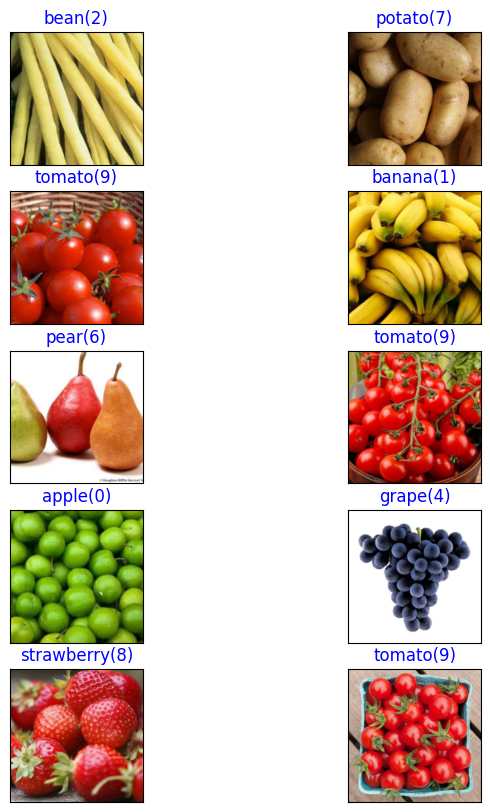

In [27]:
# Visualization of images

# get some random training images
# a quick explanation of iter() and next():
# https://stackoverflow.com/questions/62549990/what-does-next-and-iter-do-in-pytorchs-dataloader

dataiter = iter(train_loader) #iter() returns an iterator
images, labels = next(dataiter) # call next() on the iterator to get the first iteration

fig = plt.figure(figsize=(8, 10))
for idx in np.arange(int(batch_size)):
    ax = fig.add_subplot(5, int(batch_size/5), idx+1, xticks=[], yticks=[])
    img = np.squeeze(images[idx])
    plt.imshow(np.transpose(img, (1,2,0)))
    ax.set_title("{}({})".format(classes[labels[idx]],str(labels[idx].item())),
                color=("blue"))

how many images in the train set:  400
images per class:  {'apple': 40, 'banana': 40, 'bean': 40, 'carrot': 40, 'grape': 40, 'onion': 40, 'pear': 40, 'potato': 40, 'strawberry': 40, 'tomato': 40}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


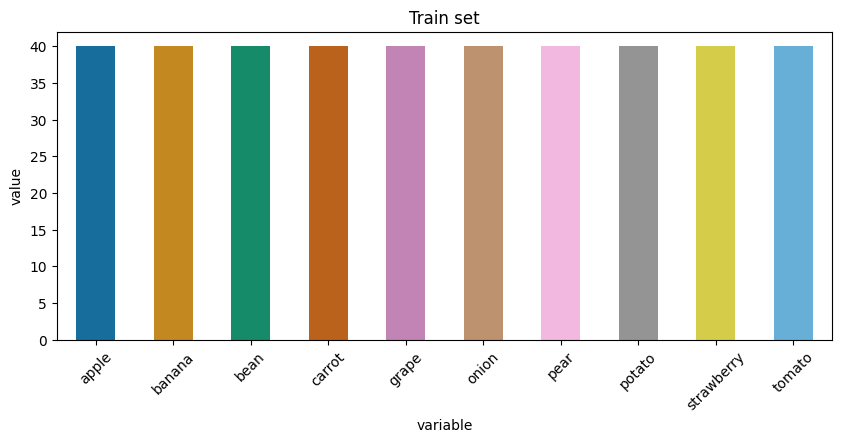

In [29]:
# class distribution
import seaborn as sns
from collections import Counter

print("how many images in the train set: ", len(train_set.targets))

# count how many images per class
count_dict = {}
for k,v in Counter(train_set.targets).items():
  count_dict[classes[k]] = v
print("images per class: ", count_dict)
plt.figure(figsize=(10, 4))
#plot the class ditribution
sns.barplot(data =pd.DataFrame.from_dict([count_dict]).melt(),
              x="variable", y="value", hue="variable", palette="colorblind", width = 0.5,  dodge=False)


plt.title("Train set")
plt.xticks(rotation=45)
plt.legend().set_visible(False)
plt.show()

## the training set is perfectly balanced: same number of image for all classes

##### 2.5 Use augmentation techniques to improve the diversity of the data for training

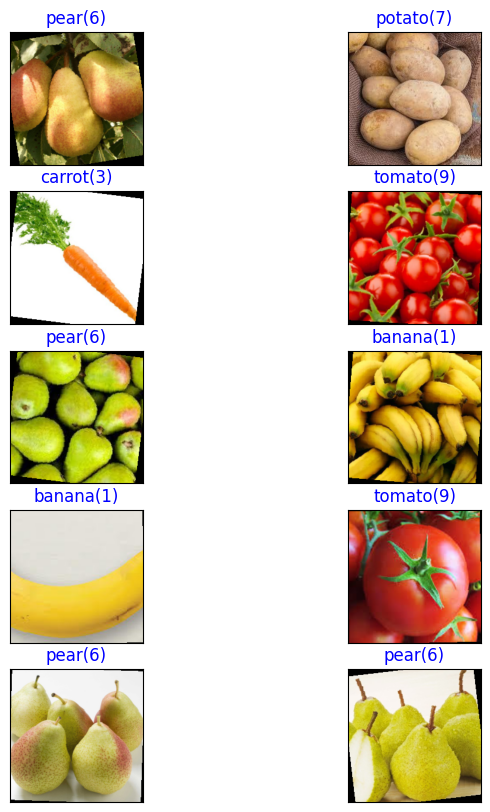

In [30]:
# Using some image transformations as augmentation techniques
# add more image transformations such as RandomHorizontalFlip and RandomRotation
train_transform_aug = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# loading the dataset again, and applying the image transformations
train_set_aug = datasets.ImageFolder(train_dir, transform  =  train_transform_aug)

batch_size = 10
train_loader_aug = torch.utils.data.DataLoader(train_set_aug, batch_size = batch_size, shuffle = True)

# Visualization of images with augmentation

dataiter = iter(train_loader_aug)
images, labels = next(dataiter)

fig = plt.figure(figsize=(8, 10))
for idx in np.arange(int(batch_size)):
    ax = fig.add_subplot(5, int(batch_size/5), idx+1, xticks=[], yticks=[])
    img = np.squeeze(images[idx])
    plt.imshow(np.transpose(img, (1,2,0)))
    ax.set_title("{}({})".format(classes[labels[idx]],str(labels[idx].item())),
                color=("blue"))

# Data license
This exercise focuses on the analysis of image licenses within the Flicker30k dataset: https://shannon.cs.illinois.edu/DenotationGraph/ .

This dataset contains 31,783 images
of individuals participating in everyday activities and events. Each image is annotated with 5 captions (short descriptive text) by humans via croudsourcing.

The image captions are released under a CreativeCommons Attribution-ShareAlike license:
https://creativecommons.org/licenses/by/3.0/

**How about the images?**

On the Flicker30k dataset page we see the following statement: *Note that the Flickr30K Dataset includes images obtained from Flickr. Use of the images must abide by the Flickr Terms of Use. We do not own the copyright of the images. They are solely provided for researchers and educators who wish to use the dataset for non-commercial research and/or educational purposes.*

**So, what are the licenses of the images? You will investigate this yourself!**

You are provided with a csv file containing the license history of some images from the Flicker30k dataset.
The license history was downloaded via Flicker API.


We provide the sample code to obtain the image information and license history below. However, to use the Flicker API an API key is required. If you are interested in directly using the Flicker API yourself, you need to apply online for a key. In today's exercise **no API key is required**, as we provided you with the data.

Your task is to:
- 2.6 check the initial images' license
- 2.7 check the current license and count the number of changes
- 2.8 count how many images changed the license from *Attribution* to *All Rights Reserved*




<!-- - usage of Flickr API to download images, images metadata and license history
- checking the initial images’ license
- checking the current license and reporting the number of changes in license
- reporting how many images changed the license from “Public Domain Mark / Public Domain Dedication (CC0)” to “Attribution-NoDerivs (CC BY-ND 2.0)” -->


In [33]:
# install Flickr API if you want to download the license history yourself
# Reminder: for today's exercises it is not required
#pip install flickrapi

Code sample for using the Flickr API to download images, image metadata, and 
license history.

In [34]:
import flickrapi
import urllib.request
from PIL import Image
from tqdm import tqdm
import argparse
import numpy as np
import time

# defining wrapping function to get info about images using the Flickr API
def get_image_info(key:str, secret:str, image_id:str):
    """
      Get information about the image from Flickr

      Arguments:
        key: FlickrAPI key
        secret: FlickerAPI code
        image: Flicker image id
    """
    flickr = flickrapi.FlickrAPI(key, secret, cache=True)
    error =False

    try:
      image_info = flickr.photos.getInfo(photo_id =image_id, format='parsed-json')
      return image_info, error
    except flickrapi.exceptions.FlickrError as ex:
      #print("Error code: %s" % ex.code)
      error = True
      return ex.code, error

# defining wrapping function to get the license history of images using the Flickr API
def get_license_history(key:str, secret:str, image_id:str):
    """
      Get the license history of an image from Flickr

      Arguments:
        key: FlickrAPI key
        secret: FlickerAPI code
        image: Flicker image id
    """
    flickr = flickrapi.FlickrAPI(key, secret, cache=True)
    error =False

    try:
      history_info = flickr.photos.licenses.getLicenseHistory(photo_id =image_id, format='parsed-json')
      return history_info, error
    except flickrapi.exceptions.FlickrError as ex:
      error = True
      return ex.code, error

In [35]:
# read the csv file containing the information about license
license_history = pd.read_csv("lab2_flicker30k_license_history.csv")
print(license_history.shape)
display(license_history)


(830, 10)


,image_name,image_id,url_working,date_of_check,flicker_license_id,license_date_change,old_license,old_license_url,new_license,new_license_url
0,1019604187.jpg,1019604187,1,1708894127,0,1186340713,All Rights Reserved,NaN,NaN,NaN
1,1039360778.jpg,1039360778,1,1708894217,4,1186490192,Attribution License,https://creativecommons.org/licenses/by/2.0/,NaN,NaN
2,1001633352.jpg,1001633352,1,1708894016,3,1186181744,Attribution-NonCommercial-NoDerivs License,https://creativecommons.org/licenses/by-nc-nd/...,NaN,NaN
3,101001624.jpg,101001624,1,1708894061,5,1140229572,Attribution-ShareAlike License,https://creativecommons.org/licenses/by-sa/2.0/,NaN,NaN
4,1029737941.jpg,1029737941,1,1708894177,2,1186420318,Attribution-NonCommercial License,https://creativecommons.org/licenses/by-nc/2.0/,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
825,10350842.jpg,10350842,1,1708894209,5,1114146579,Attribution-ShareAlike License,https://creativecommons.org/licenses/by-sa/2.0/,NaN,NaN
826,1021332107.jpg,1021332107,1,1708894133,1,1186353637,Attribution-NonCommercial-ShareAlike License,https://creativecommons.org/licenses/by-nc-sa/...,NaN,NaN
827,1052358063.jpg,1052358063,1,1708894279,0,1186596806,All Rights Reserved,NaN,NaN,NaN
828,1007205537.jpg,1007205537,1,1708894044,1,1186238229,Attribution-NonCommercial-ShareAlike License,https://creativecommons.org/licenses/by-nc-sa/...,NaN,NaN


##### 2.6 Check the initial/old images’ license.

In [36]:

# check out the initial/old license
pd.options.display.min_rows = 35
license_history["old_license"]


0                               All Rights Reserved
1                               Attribution License
2        Attribution-NonCommercial-NoDerivs License
3                    Attribution-ShareAlike License
4                 Attribution-NonCommercial License
5      Attribution-NonCommercial-ShareAlike License
6                               All Rights Reserved
7        Attribution-NonCommercial-NoDerivs License
8        Attribution-NonCommercial-NoDerivs License
9      Attribution-NonCommercial-ShareAlike License
10     Attribution-NonCommercial-ShareAlike License
11                     Attribution-NoDerivs License
12                     Attribution-NoDerivs License
13     Attribution-NonCommercial-ShareAlike License
14                              All Rights Reserved
15                Attribution-NonCommercial License
16                              All Rights Reserved
                           ...                     
813                  Attribution-ShareAlike License
814         

How many images had *All rights Reserved* as initial license?

In [42]:
# count how many images had All rights Reserved as initial license
# YOUR CODE HERE
# raise NotImplementedError()

license_history["old_license"].value_counts()



old_license
Attribution-NonCommercial-NoDerivs License      230
All Rights Reserved                             225
Attribution-NonCommercial-ShareAlike License    150
Attribution License                              80
Attribution-NonCommercial License                50
Attribution-NoDerivs License                     50
Attribution-ShareAlike License                   45
Name: count, dtype: int64

##### 2.7 Check the current license and count the number of changes in the license.


In [ ]:
# check out the new license
# a value of NaN means that there was no change in the license over time (no new license)
# and we should refer to the initial license
license_history["new_license"]

In [43]:
# count how many images changed license over time
#(1 line of code)
# YOUR CODE HERE
# raise NotImplementedError()
license_history["new_license"].value_counts()

new_license
Attribution-NonCommercial-NoDerivs License      35
Attribution-NonCommercial License               20
Attribution-NonCommercial-ShareAlike License    15
All Rights Reserved                             15
Attribution-ShareAlike License                   5
Attribution License                              5
Attribution-NoDerivs License                     5
Name: count, dtype: int64

##### 2.8 Count how many images changed the license from Attribution-NonCommercial License to All rights reserved.


In [ ]:
# one solution could be the following:
# select the rows that have old license Attribution-NonCommercial License
# (1 line of code)
# then count how many of the previously selected rows have new license All rights reserved
# (1 line of code)
# YOUR CODE HERE
raise NotImplementedError()